In [1]:
from scipy import optimize 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import params as prm
import feo_thermodynamics

Pr =  0.09075  Sc =  999.9999999999999


The next cell implements the following equations to calculate the number and size of particles falling out of the F-layer at the Stokes velocity. 

$$ V_E = \frac{4 \pi r^3 N}{3} , \quad 4\pi r^3 N P V_s = 4\pi r_i^2 \frac{d r_i}{dt}, \quad V_S = \frac{2}{9} \frac{\Delta \rho g r^2}{\mu} $$

$$ r^5 N P \frac{2}{9} \frac{\Delta \rho}{\mu} = r_i^2 \frac{d r_i}{dt} $$
$$ r^2 = \frac{4 \pi r^5 N}{3 V_e}$$

We use the Zhang formulation to calculate $V_s$ and therefore guess at the particle radius $r$ in order to estimate $N$. I use brentq to converge to a solution. 

In [2]:
def meanPsize_closure():
    
    params = {}

    def meanPsize(t_snow, dridt, ri, mu, Vfrac):
        """
        Evaluate the mean size and number of particles in the snowing layer
        
        t_snow: thickness of the snowing layer (in m)
        dridt: chage in ICB radius with time (m/s)
        ri: ICB radius (in m)
        mu: kinematic viscosity
        Vfrac: volume fraction of solid
        """
        assert t_snow > 0, "Snowing layer must have positive thickness"
        rtop    = ri + t_snow
        Vflayer = 4.0 * np.pi * (rtop**3 - ri**3) / 3.0 
        Ve    = Vfrac * Vflayer 
        Pack  = 0.67
        r5N   = 9.0 * (mu * ri**2 * dridt) / (2.0 * prm.drho * prm.g * Pack) 
        r2    = 4 * np.pi * r5N / (3.0*Ve)
        r     = np.sqrt(r2)
        N     = 3.0 * Ve / (4.0 * np.pi * r**3) 
        Vs    = (2.0/9.0) * prm.drho * prm.g * r2 / (mu)
        t     = (rtop-ri)/Vs
            
        if Ve < 0:
            t = -1.0
                  
        params['r']  = r
        params['N']  = N
        params['Vs'] = Vs
        params['Ve'] = Ve
        params['t']  = t
        params['rf'] = t_snow   
    
        return t-prm.secinyr
    
    return params, meanPsize



In [3]:
# An example case?

# Work out a volume fraction solid
t = 5400.0 # K
x = 0.04 # wt frac O
p = 330.0 # GPa

x_lq, phi_fe, phi_lq, phi_feo, phi_solid = \
        feo_thermodynamics.phase_relations_molar(
            feo_thermodynamics.mol_frac_fe(x*100.0), p, t)
print("Temperature:", t, "K, bulk wt. frac O:", x, "pressure:", p, "GPa")
print("Mol frac solid Fe:", phi_fe)
print("Mol frac solid FeO:", phi_feo)
print("Mol frac liquid:", phi_lq)
print("FeO mol. frac in liquid:", 1.0-x_lq)
    
Vfrac = feo_thermodynamics.volume_fraction_solid(feo_thermodynamics.mol_frac_fe(x*100.0), p, t)
print("Volume fraction solid:", Vfrac)

# Work out particle number and size...
dridt   = 1e-3 / prm.secinyr
mu_test = 1e-6 * prm.rhol

params, meanPsize = meanPsize_closure()
optimize.brentq(meanPsize, 0.001, 1e3, args=(dridt, prm.ri, mu_test, Vfrac))

print('layer thickness = ', params['rf'], 'm')
print('Ve    = ', params['Ve'])
print('Vs    = ', params['Vs'], ' m/s')
print('dridt = ', dridt, ' m/s')
print('t     = ', params['t']/prm.secinyr, ' yrs')
print('r, N = ', params['r'], params['N'])

Temperature: 5400.0 K, bulk wt. frac O: 0.04 pressure: 330.0 GPa
Mol frac solid Fe: 0.019250635835613927
Mol frac solid FeO: 0.0
Mol frac liquid: 0.9807493641643861
FeO mol. frac in liquid: 0.14828981453555412
Volume fraction solid: 0.017477617492032468
layer thickness =  0.16871776978875233 m
Ve    =  55243897130.51649
Vs    =  5.350005391190617e-09  m/s
dridt =  3.1709791983764586e-11  m/s
t     =  0.9999999979640962  yrs
r, N =  3.6224263529362823e-07 2.7745784233737467e+29


In [4]:
# Loop over a range of viscosities and IC growth rates

dridt = np.logspace(-4, -2, 10)/prm.secinyr
muA   = np.logspace(-7, -5, 10)
nuA   = muA * prm.rhol

Nv    = np.zeros((len(dridt),len(nuA))) # v denotes vector here
rv    = np.zeros((len(dridt),len(nuA)))
Vev   = np.zeros((len(dridt),len(nuA)))
Vsv   = np.zeros((len(dridt),len(nuA)))
rfv   = np.zeros((len(dridt),len(nuA)))

ii = 0
for i in dridt:
    jj = 0
    for j in nuA:
        optimize.brentq(meanPsize, 1e-8, 1e4, args=(i, prm.ri, j, Vfrac))
        Nv[ii,jj]  = params['N']
        rv[ii,jj]  = params['r']
        Vev[ii,jj] = params['Ve']
        Vsv[ii,jj] = params['Vs']
        rfv[ii,jj] = params['rf']        
                
        jj = jj + 1
        
    ii = ii + 1
    
print('Rmax = ', np.max(rv), ' Rmin = ', np.min(rv))

Rmax =  2.0370398828118296e-06  Rmin =  6.44168635387902e-08


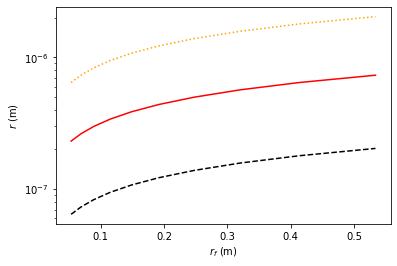

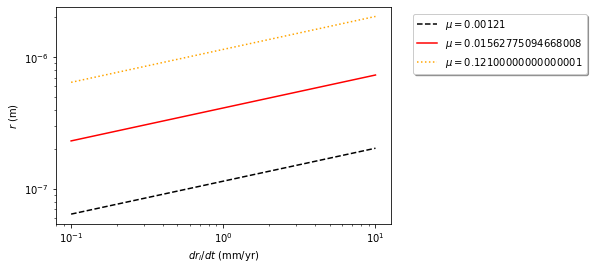

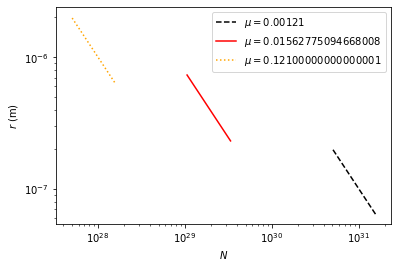

In [5]:
# Plot results
fig, ax = plt.subplots()
ax.set_xlabel("$r_f$ (m)")
ax.set_ylabel("$r$ (m)")
ax.set_yscale('log')
ax.plot(rfv[:,0], rv[:,0], color="black" , linestyle="--",label="$\\mu = $"+str(nuA[0]))
ax.plot(rfv[:,5], rv[:,5], color="red"   , linestyle="-" ,label="$\\mu = $"+str(nuA[5]))
ax.plot(rfv[:,9], rv[:,9], color="orange", linestyle=":" ,label="$\\mu = $"+str(nuA[9]))
#ax.legend(loc='upper right', bbox_to_anchor=(1.6, 0.99),
#          fancybox=True, shadow=True)
file2="Vf.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("$dr_i/dt$ (mm/yr)")
ax.set_ylabel("$r$ (m)")
ax.plot(dridt*prm.secinyr*1000, rv[:,0], color="black" , linestyle="--",label="$\\mu = $"+str(nuA[0]))
ax.plot(dridt*prm.secinyr*1000, rv[:,5], color="red"   , linestyle="-" ,label="$\\mu = $"+str(nuA[5]))
ax.plot(dridt*prm.secinyr*1000, rv[:,9], color="orange", linestyle=":" ,label="$\\mu = $"+str(nuA[9]))
ax.legend(loc='upper right', bbox_to_anchor=(1.6, 0.99),
          fancybox=True, shadow=True)


fig, ax = plt.subplots()
ax.set_xlabel("$N$")
ax.set_ylabel("$r$ (m)")
ax.loglog(Nv[:,0], rv[:,0], color="black" , linestyle="--",label="$\\mu = $"+str(nuA[0]))
ax.loglog(Nv[:,5], rv[:,5], color="red"   , linestyle="-" ,label="$\\mu = $"+str(nuA[5]))
ax.loglog(Nv[:,9], rv[:,9], color="orange", linestyle=":" ,label="$\\mu = $"+str(nuA[9]))
ax.legend(loc=1)
file2="rN.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")